In [1]:
import os
# Suppress oneDNN optimizations and lower TensorFlow logging level
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Load the data set  
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the pixel values  
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Expand dimensions to match the input shape (28, 28, 1)  
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Add noise to the data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to be within the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


### Build the diffusion model
**1. Define the encoder:**
- Create an input layer with the shape (28, 28, 1). 
- Add two Conv2D layers with increasing filter sizes and ReLU activation. 

**2. Define the bottleneck:**
- Add a flattened layer followed by a dense layer with ReLU activation. 

**3. Define the decoder:**
- Add a Dense layer to expand the bottleneck representation.  
- Reshape the output to match the original image dimensions.  
- Add two Conv2DTranspose layers with decreasing filter sizes and ReLU activation.
  
**4. Compile the model:**
- Use the Adam optimizer and binary cross-entropy loss. 

In [3]:
# Define the diffusion model architecture with reduced complexity
input_layer = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)  # Reduced filters
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
x = Flatten()(x)
x = Dense(64, activation='relu')(x)  # Reduced size
x = Dense(28*28*32, activation='relu')(x)  # Reduced size
x = Reshape((28, 28, 32))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
diffusion_model = Model(input_layer, output_layer)

# Compile the model with mixed precision and a different loss function
diffusion_model.compile(optimizer='adam', loss='mean_squared_error')  # Using MSE for regression tasks

# Summary of the optimized model
diffusion_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25088)          │     1,630,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,255,233 (12.42 MB)

 Trainable params: 3,255,233 (12.42 MB)

 Non-trainable params: 0 (0.00 B)

### Add noise to the data

- Add Gaussian noise to the training and test data sets.  
- Clip the values to ensure they remain within the valid range [0, 1].  

In [5]:
# Cache and prefetch the data using TensorFlow data pipelines for faster loading
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train))
train_dataset = train_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size

val_dataset = tf.data.Dataset.from_tensor_slices((x_test_noisy, x_test))
val_dataset = val_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size

### Train the diffusion model
- Use the ‘fit’ method to train the model on the noisy training data. 
- Set the number of epochs to 50 and the batch size to 128. 

In [6]:
# Implement early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping and smaller batch size
diffusion_model.fit(
    train_dataset,
    epochs=3,
    shuffle=True,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - loss: 0.0518 - val_loss: 0.0158
Epoch 2/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - loss: 0.0138 - val_loss: 0.0131
Epoch 3/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - loss: 0.0116 - val_loss: 0.0124


### Evaluate the diffusion model
**1. Reconstruct images:**
- Use the diffusion model to predict the denoised test images.  
- Compare the original, noisy, and denoised images. 

**2. Visualize the results:**
- Plot a few examples of original, noisy, and denoised images side by side. 

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


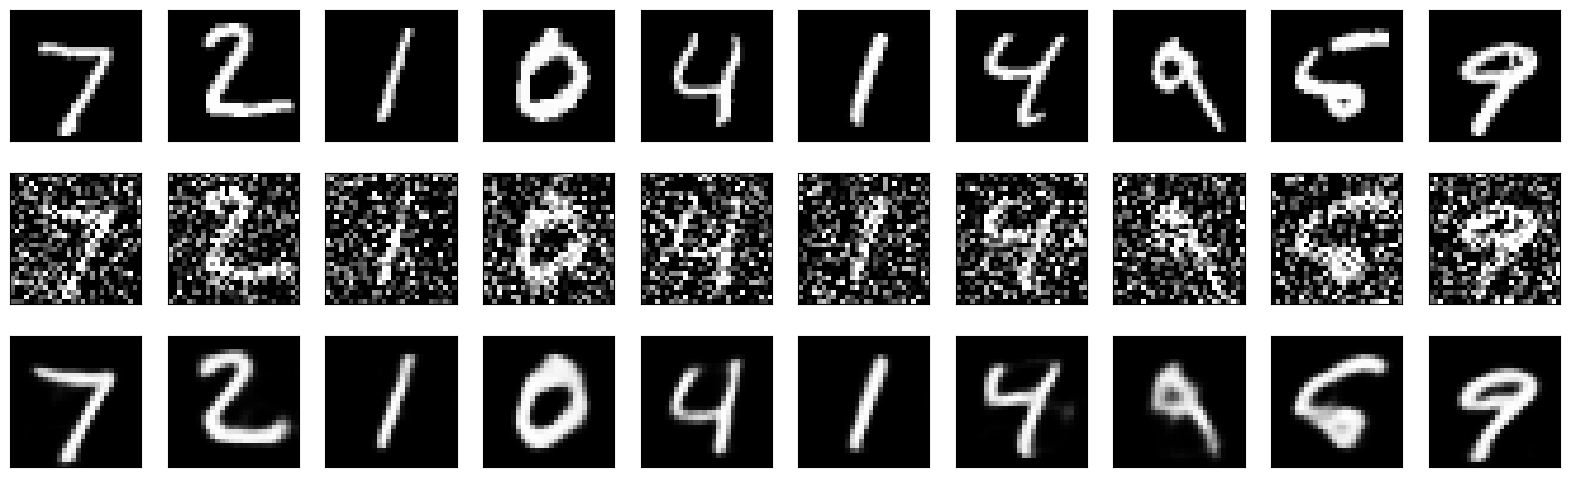

In [7]:
import matplotlib.pyplot as plt

# Predict the denoised images
denoised_images = diffusion_model.predict(x_test_noisy)

# Visualize the results
n = 10  # Number of digits to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Modify the noise factor
1. Change the noise factor to 0.3.  
2. Add noise to the training and test data sets with the new noise factor.  
3. Retrain the model with the new noisy data.

In [8]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to be within the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping and smaller batch size
diffusion_model.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stopping]
)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - loss: 0.0069 - val_loss: 0.0060
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 61ms/step - loss: 0.0059 - val_loss: 0.0058
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 61ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 61ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - loss: 0.0051 - val_loss: 0.0055
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 61ms/step - loss: 0.0049 - val_loss: 0.0055
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 61ms/step - loss: 0.0048 - val_loss: 0.0055
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 61ms/step - loss: 0.0046 - val_loss: 0.0054
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 60ms/step - loss: 0.0044 - val_loss: 0.0055
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 60ms/step - loss: 0.0042 - val_loss: 0.0055
